# Importing Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from tqdm.notebook import tqdm
import spacy
nlp = spacy.load("en_core_web_sm")

# Reading in the excel data

In [3]:
df = pd.read_excel('Airplane_Crashes_and_Fatalities_Since_1908.xlsx')

In [4]:
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,1908-09-17,17:18:00,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1912-07-12,06:30:00,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,1913-09-09,18:30:00,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,1913-10-17,10:30:00,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5268 non-null   datetime64[ns]
 1   Time          3049 non-null   object        
 2   Location      5248 non-null   object        
 3   Operator      5250 non-null   object        
 4   Flight #      1069 non-null   object        
 5   Route         3562 non-null   object        
 6   Type          5241 non-null   object        
 7   Registration  4933 non-null   object        
 8   cn/In         4040 non-null   object        
 9   Aboard        5246 non-null   float64       
 10  Fatalities    5256 non-null   float64       
 11  Ground        5246 non-null   float64       
 12  Summary       4878 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(9)
memory usage: 535.2+ KB


# Creating a function to get the country code for the location of the crash

In [31]:
URL = "https://geocoder.ls.hereapi.com/search/6.2/geocode.json"
api_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'  # Acquire api key from developer.here.com

def getCoordinates(location):
    PARAMS = {'searchtext': location, 'apikey': api_key} # required parameters
    r = requests.get(url=URL, params=PARAMS)  # pass in required parameters
    data = r.json() # Raw json file
    try:
        country = data['Response']['View'][0]['Result'][0]['Location']['Address']['Country']
        return country
    except:
        return 'Unknown'

In [ ]:
data = df.copy().reset_index()

hereloc = {}

In [63]:
#This would take at least 1 hr to run so you can use the incomplete.xlsx file and follow along
for i, row in tqdm(data.iterrows(), total=len(data), miniters=1):
    myid = row['index']
    locate = row['Location']

    country_code = getCoordinates(locate)
    hereloc[myid] = [country_code]

  0%|          | 0/2428 [00:00<?, ?it/s]

In [78]:
df['country_code'] = pd.DataFrame.from_dict(hereloc, orient='index')

Viewing the new dataframe

In [217]:
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,country_code
0,1908-09-17,17:18:00,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",USA
1,1912-07-12,06:30:00,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,USA
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...,CAN
3,1913-09-09,18:30:00,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...,Unknown
4,1913-10-17,10:30:00,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...,DEU


# Text Clustering

This function was to get the lower case root version of each word in the summary column

In [893]:
def stem_punct_stop(word):
    lt = []
    for tokens in nlp(word):
        if (tokens.is_punct) | (tokens.pos_ == 'NUM') | (tokens.is_stop):
            #checking if the word is a punctuation, a number or a stopword
            continue
        lt.append(tokens.lemma_.lower())
    return ' '.join(lt)

In [894]:
lem_text = df['Summary'].dropna().apply(stem_punct_stop)

KMeans generally only works with numbers so we'll use an extraction tool to get numbers.

The feature extraction tool used is TF-IDF, which is a numerical statistic. The term frequency and inverse document frequency are used in this statistic.

In [895]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from kneed import KneeLocator #to locate the elbow (number of clusters)

In [896]:
text = list(lem_text)

tv = TfidfVectorizer(stop_words='english')
X = tv.fit_transform(text)

Steps involved in choosing the number of clusters to use

In [902]:
ses = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    ses.append(kmeans.inertia_)

Text(0, 0.5, 'SES')

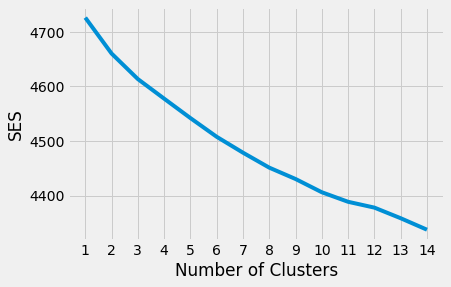

In [903]:
plt.plot(range(1, 15), ses)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SES")

In [904]:
# To locate the elbow, i.e. the recommended number of clusters to use
KneeLocator(range(1, 15), ses, curve="convex", direction="decreasing").elbow

6

In [905]:
model = KMeans(n_clusters=6, random_state=2)
model.fit(X)

KMeans(n_clusters=6, random_state=2)

In [906]:
model.cluster_centers_.argsort().shape

(6, 7669)

In [1174]:
print('Most common terms')
order_centroids = model.cluster_centers_.argsort()[:,::-1] #Sort cluster centers by proximity to centroid
terms = tv.get_feature_names() #To get the word

for i in range(6):
    print('\n')
    print(f'Cluster {i}')
    for j in order_centroids[i, :20]:
        print(f'{terms[j]}')



Cluster 0
en
route
crash
mountain
disappear
plane
cargo
wreckage
aircraft
mountainous
poor
terrain
weather
strike
miss
mt
undetermined
flight
sea
mail


Cluster 1
approach
runway
crash
land
attempt
plane
short
cargo
aircraft
landing
fog
strike
tree
pilot
crew
airport
ground
heavy
altitude
final


Cluster 2
crash
aircraft
plane
pilot
flight
control
fly
sea
crew
cause
ground
shoot
air
altitude
kill
failure
airport
mile
ft
shortly


Cluster 3
mountain
crash
strike
fly
ft
poor
plane
cargo
fog
approach
weather
course
hit
cloud
aircraft
visibility
attempt
mile
shortly
obscure


Cluster 4
weather
condition
vfr
adverse
poor
flight
continued
pilot
crash
fly
mountain
ifr
low
terrain
route
attempt
fog
en
altitude
plane


Cluster 5
engine
takeoff
crash
failure
shortly
plane
lose
aircraft
emergency
fail
landing
power
right
experience
return
cargo
fuel
left
airport
pilot


In [912]:
pd.DataFrame(model.labels_).value_counts() #Most common cluster

2    2650
1     874
5     613
4     276
0     233
3     232
dtype: int64

To test the clusters with words

In [1196]:
word = stem_punct_stop(nlp('engine failure'))

model.predict(tv.transform([word]))

array([5])

# Adding the cluster column to the dataframe and saving

In [923]:
sum_index = df['Summary'].dropna().index

In [924]:
cluster_df = df[['Summary']].join(pd.DataFrame(model.labels_, index=sum_index, columns=['model']))

In [925]:
cluster_df.head()

,Summary,model
0,"During a demonstration flight, a U.S. Army fly...",2.0
1,First U.S. dirigible Akron exploded just offsh...,2.0
2,The first fatal airplane accident in Canada oc...,2.0
3,The airship flew into a thunderstorm and encou...,2.0
4,Hydrogen gas which was being vented was sucked...,2.0


In [939]:
cluster_df.isna().sum()

Summary    390
model      390
dtype: int64

In [945]:
df['cluster_label'] = cluster_df['model']

In [947]:
fill_df = df.fillna('unknown')

In [949]:
fill_df.to_excel('complete.xlsx')

In [950]:
df.to_excel('incomplete.xlsx')